In [1]:
import tensorflow as tf
import os
import numpy as np
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm

2024-05-21 20:13:06.297845: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 20:13:06.297955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 20:13:06.436268: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
# Define the path for the empty folder
folder_path = '/kaggle/working/empty_folderf3/'

# Create the empty folder
os.makedirs(folder_path, exist_ok=True)
save_dir = ('/kaggle/working/empty_folderf3')


In [3]:
from sklearn.model_selection import train_test_split

# Split dataset into training and validation sets
train_dir = '/kaggle/input/gtsrb-train/Train'
train_data, val_data = train_test_split(os.listdir(train_dir), test_size=0.2, random_state=42)

# Create training and validation datasets
train_dataset = keras.preprocessing.image_dataset_from_directory(
    directory=train_dir, 
    labels='inferred',  # Use inferred labels from directory structure
    label_mode='categorical', 
    image_size=(64,64), 
    batch_size=64,
    shuffle=True,
    validation_split=0.2,  # Percentage of data to use for validation
    subset="training",
    seed=42  # Specify seed for reproducibility
).map(lambda x, y: (x/255.0, y))  # Normalize the pixel values to [0, 1]

val_dataset = keras.preprocessing.image_dataset_from_directory(
    directory=train_dir, 
    labels='inferred',  # Use inferred labels from directory structure
    label_mode='categorical', 
    image_size=(64,64), 
    batch_size=64,
    shuffle=True,
    validation_split=0.2,  # Percentage of data to use for validation
    subset="validation",
    seed=42  # Specify seed for reproducibility
).map(lambda x, y: (x/255.0, y))  # Normalize the pixel values to [0, 1])


Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [4]:
#nnnnnnneeeeewwwwwwwwww   mmmmooodeeel

In [5]:
latent_dim = 128

# Encoder
encoder = keras.Sequential([
    layers.Input(shape=(64,64, 3)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Flatten(),
    layers.Dense(latent_dim)  # Latent representation
])

# Decoder
decoder = keras.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(8*8*512),
    layers.Reshape((8,8, 512)),
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(3, kernel_size=4,  padding="same", activation="tanh"),
])

# Full autoencoder model
autoencoder = keras.Sequential([
    layers.Input(shape=(64,64,3)),
    encoder,
    decoder
])


In [6]:
from tensorflow.keras import layers, models, optimizers

In [7]:
import tensorflow as tf

def create_model():
    inputs = tf.keras.Input(shape=(64, 64, 3))
    
    x = tf.keras.layers.Conv2D(200, kernel_size=3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='same')(x)  # Output shape: (24, 24, 250)
    
    x = tf.keras.layers.Conv2D(300, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='same')(x)  # Output shape: (12, 12, 300)
   
    
    x = tf.keras.layers.Conv2D(450, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='same')(x)  # Output shape: (3, 3, 400)
    
    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(600, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(400, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)   
    outputs = tf.keras.layers.Dense(43, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# Create an instance of the model
discriminator = create_model()




In [8]:
# Loss functions
loss_fn_auto = tf.keras.losses.MeanSquaredError()
loss_fn_disc = tf.keras.losses.CategoricalCrossentropy()

# Optimizers
opt_autoencoder = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
opt_disc = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)


# Compile the autoencoder model
autoencoder.compile(optimizer=opt_autoencoder, loss=loss_fn_auto)

# Compile the discriminator model
discriminator.compile(optimizer=opt_disc, loss=loss_fn_disc, metrics=['accuracy'])

In [9]:
autoencoder_losses_epoch = []
discriminator_losses_epoch = []
discriminator_acc_epoch = []
val_autoencoder_losses_epoch = []
val_discriminator_losses_epoch = []
val_discriminator_acc_epoch = []

for epoch in range(100):
    # Initialize epoch-wise metrics
    epoch_autoencoder_losses = []
    epoch_discriminator_losses = []
    epoch_discriminator_acc = []
    epoch_val_autoencoder_losses = []
    epoch_val_discriminator_losses = []
    epoch_val_discriminator_acc = []

    # Training loop
    for idx, (batch_real, batch_label) in enumerate(tqdm(train_dataset)):
        # Training steps
        with tf.GradientTape() as autoencoder_tape, tf.GradientTape() as disc_tape:
            latent_representation = encoder(batch_real)
            generated_image = decoder(latent_representation)
            loss_autoencoder = loss_fn_auto(batch_real, generated_image)
            
            fake = generated_image
            loss_disc_real = loss_fn_disc(batch_label, discriminator(batch_real))
            loss_disc_fake = loss_fn_disc(batch_label, discriminator(fake))
            loss_disc = (loss_disc_real + loss_disc_fake) / 2

        grads_autoencoder = autoencoder_tape.gradient(loss_autoencoder, autoencoder.trainable_weights)
        opt_autoencoder.apply_gradients(zip(grads_autoencoder, autoencoder.trainable_weights))

        grads_discriminator = disc_tape.gradient(loss_disc, discriminator.trainable_weights)
        opt_disc.apply_gradients(zip(grads_discriminator, discriminator.trainable_weights))

        # Store batch-wise metrics
        epoch_autoencoder_losses.append(loss_autoencoder.numpy())
        epoch_discriminator_losses.append(loss_disc.numpy())
        epoch_discriminator_acc.append(tf.reduce_mean(tf.keras.metrics.categorical_accuracy(batch_label, discriminator(fake))).numpy())
        if idx % 200 == 0:
            img = tf.keras.preprocessing.image.array_to_img(fake[0])
            img.save(f"{save_dir}/generated_img_epoch_{epoch}_batch_{idx}.png")

    # Validation loop
    for val_batch_real, val_batch_label in val_dataset:
        val_latent_representation = encoder(val_batch_real)
        val_generated_image = decoder(val_latent_representation)
        val_loss_autoencoder = loss_fn_auto(val_batch_real, val_generated_image)
        val_loss_disc_real = loss_fn_disc(val_batch_label, discriminator(val_batch_real))
        val_loss_disc_fake = loss_fn_disc(val_batch_label, discriminator(val_generated_image))
        val_loss_disc = (val_loss_disc_real + val_loss_disc_fake) / 2

        # Calculate accuracy
        val_discriminator_accuracy = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(val_batch_label, discriminator(val_generated_image)))

        # Store validation metrics
        epoch_val_autoencoder_losses.append(val_loss_autoencoder.numpy())
        epoch_val_discriminator_losses.append(val_loss_disc.numpy())
        epoch_val_discriminator_acc.append(val_discriminator_accuracy.numpy())

    # Calculate epoch-wise averages and append to the lists
    avg_autoencoder_loss = np.mean(epoch_autoencoder_losses)
    avg_discriminator_loss = np.mean(epoch_discriminator_losses)
    avg_discriminator_acc = np.mean(epoch_discriminator_acc)
    avg_val_autoencoder_loss = np.mean(epoch_val_autoencoder_losses)
    avg_val_discriminator_loss = np.mean(epoch_val_discriminator_losses)
    avg_val_discriminator_acc = np.mean(epoch_val_discriminator_acc)

    autoencoder_losses_epoch.append(avg_autoencoder_loss)
    discriminator_losses_epoch.append(avg_discriminator_loss)
    discriminator_acc_epoch.append(avg_discriminator_acc)
    val_autoencoder_losses_epoch.append(avg_val_autoencoder_loss)
    val_discriminator_losses_epoch.append(avg_val_discriminator_loss)
    val_discriminator_acc_epoch.append(avg_val_discriminator_acc)

    # Print epoch-wise metrics
    print(f"Epoch {epoch}, Autoencoder Loss: {avg_autoencoder_loss}, Discriminator Loss: {avg_discriminator_loss}, Discriminator Accuracy: {avg_discriminator_acc}")
    print(f"Validation - Autoencoder Loss: {avg_val_autoencoder_loss}, Discriminator Loss: {avg_val_discriminator_loss}, Discriminator Accuracy: {avg_val_discriminator_acc}")


100%|██████████| 491/491 [02:29<00:00,  3.28it/s]


Epoch 0, Autoencoder Loss: 0.02516150288283825, Discriminator Loss: 2.4294371604919434, Discriminator Accuracy: 0.2120353877544403
Validation - Autoencoder Loss: 0.01600843295454979, Discriminator Loss: 1.5126878023147583, Discriminator Accuracy: 0.3436730206012726


100%|██████████| 491/491 [02:13<00:00,  3.68it/s]


Epoch 1, Autoencoder Loss: 0.011830613017082214, Discriminator Loss: 0.8072725534439087, Discriminator Accuracy: 0.7416624426841736
Validation - Autoencoder Loss: 0.009971658699214458, Discriminator Loss: 0.49806898832321167, Discriminator Accuracy: 0.750053882598877


100%|██████████| 491/491 [02:13<00:00,  3.68it/s]


Epoch 2, Autoencoder Loss: 0.008328892290592194, Discriminator Loss: 0.30480852723121643, Discriminator Accuracy: 0.9360997676849365
Validation - Autoencoder Loss: 0.007582139223814011, Discriminator Loss: 0.27101653814315796, Discriminator Accuracy: 0.8688216209411621


100%|██████████| 491/491 [02:13<00:00,  3.69it/s]


Epoch 3, Autoencoder Loss: 0.006723714992403984, Discriminator Loss: 0.1505873054265976, Discriminator Accuracy: 0.9822428822517395
Validation - Autoencoder Loss: 0.005932009778916836, Discriminator Loss: 0.18567988276481628, Discriminator Accuracy: 0.9255743026733398


100%|██████████| 491/491 [02:12<00:00,  3.69it/s]


Epoch 4, Autoencoder Loss: 0.005459894426167011, Discriminator Loss: 0.07712702453136444, Discriminator Accuracy: 0.9948446750640869
Validation - Autoencoder Loss: 0.005247697699815035, Discriminator Loss: 0.12172341346740723, Discriminator Accuracy: 0.9559274315834045


100%|██████████| 491/491 [02:14<00:00,  3.65it/s]


Epoch 5, Autoencoder Loss: 0.004926054272800684, Discriminator Loss: 0.05366886034607887, Discriminator Accuracy: 0.9975178241729736
Validation - Autoencoder Loss: 0.004765521269291639, Discriminator Loss: 0.10266603529453278, Discriminator Accuracy: 0.956959068775177


100%|██████████| 491/491 [02:21<00:00,  3.46it/s]


Epoch 6, Autoencoder Loss: 0.004330075345933437, Discriminator Loss: 0.032169364392757416, Discriminator Accuracy: 0.9991407990455627
Validation - Autoencoder Loss: 0.0050840857438743114, Discriminator Loss: 0.08362356573343277, Discriminator Accuracy: 0.9701550602912903


100%|██████████| 491/491 [02:12<00:00,  3.69it/s]


Epoch 7, Autoencoder Loss: 0.003985333256423473, Discriminator Loss: 0.026918765157461166, Discriminator Accuracy: 0.9993953704833984
Validation - Autoencoder Loss: 0.005460541695356369, Discriminator Loss: 0.067681223154068, Discriminator Accuracy: 0.9786585569381714


100%|██████████| 491/491 [02:13<00:00,  3.67it/s]


Epoch 8, Autoencoder Loss: 0.003726123133674264, Discriminator Loss: 0.03083549626171589, Discriminator Accuracy: 0.998854398727417
Validation - Autoencoder Loss: 0.0037907215300947428, Discriminator Loss: 0.08420563489198685, Discriminator Accuracy: 0.9743471145629883


100%|██████████| 491/491 [02:15<00:00,  3.63it/s]


Epoch 9, Autoencoder Loss: 0.003589813830330968, Discriminator Loss: 0.022408396005630493, Discriminator Accuracy: 0.9987907409667969
Validation - Autoencoder Loss: 0.0038803881034255028, Discriminator Loss: 0.05292558670043945, Discriminator Accuracy: 0.9813339114189148


100%|██████████| 491/491 [02:13<00:00,  3.68it/s]


Epoch 10, Autoencoder Loss: 0.0033073609229177237, Discriminator Loss: 0.017904112115502357, Discriminator Accuracy: 0.9996181130409241
Validation - Autoencoder Loss: 0.0035557476803660393, Discriminator Loss: 0.05361863598227501, Discriminator Accuracy: 0.9837475419044495


100%|██████████| 491/491 [02:13<00:00,  3.67it/s]


Epoch 11, Autoencoder Loss: 0.0031852771062403917, Discriminator Loss: 0.013084489852190018, Discriminator Accuracy: 0.9996817708015442
Validation - Autoencoder Loss: 0.00318113318644464, Discriminator Loss: 0.046882033348083496, Discriminator Accuracy: 0.9851372241973877


100%|██████████| 491/491 [02:13<00:00,  3.67it/s]


Epoch 12, Autoencoder Loss: 0.003005567006766796, Discriminator Loss: 0.011205311864614487, Discriminator Accuracy: 0.9996499419212341
Validation - Autoencoder Loss: 0.003142088418826461, Discriminator Loss: 0.04265911877155304, Discriminator Accuracy: 0.9870426654815674


100%|██████████| 491/491 [02:13<00:00,  3.67it/s]


Epoch 13, Autoencoder Loss: 0.003063366049900651, Discriminator Loss: 0.01811591535806656, Discriminator Accuracy: 0.998886227607727
Validation - Autoencoder Loss: 0.003145115915685892, Discriminator Loss: 0.04228925332427025, Discriminator Accuracy: 0.9864075183868408


100%|██████████| 491/491 [02:13<00:00,  3.67it/s]


Epoch 14, Autoencoder Loss: 0.0028302581049501896, Discriminator Loss: 0.03288159891963005, Discriminator Accuracy: 0.9981224536895752
Validation - Autoencoder Loss: 0.003007193561643362, Discriminator Loss: 0.06683138012886047, Discriminator Accuracy: 0.9784121513366699


100%|██████████| 491/491 [02:13<00:00,  3.68it/s]


Epoch 15, Autoencoder Loss: 0.002666501561179757, Discriminator Loss: 0.007884535007178783, Discriminator Accuracy: 0.9998726844787598
Validation - Autoencoder Loss: 0.003340829396620393, Discriminator Loss: 0.04392084851861, Discriminator Accuracy: 0.9870426654815674


100%|██████████| 491/491 [02:13<00:00,  3.68it/s]


Epoch 16, Autoencoder Loss: 0.002727268263697624, Discriminator Loss: 0.009330298751592636, Discriminator Accuracy: 0.9997772574424744
Validation - Autoencoder Loss: 0.0031814638059586287, Discriminator Loss: 0.04093761369585991, Discriminator Accuracy: 0.9884477257728577


100%|██████████| 491/491 [02:13<00:00,  3.67it/s]


Epoch 17, Autoencoder Loss: 0.002611679956316948, Discriminator Loss: 0.018516452983021736, Discriminator Accuracy: 0.998854398727417
Validation - Autoencoder Loss: 0.0028007328510284424, Discriminator Loss: 0.03873971104621887, Discriminator Accuracy: 0.9889481663703918


100%|██████████| 491/491 [02:13<00:00,  3.67it/s]


Epoch 18, Autoencoder Loss: 0.002444023033604026, Discriminator Loss: 0.005373172927647829, Discriminator Accuracy: 0.9999363422393799
Validation - Autoencoder Loss: 0.00289603928104043, Discriminator Loss: 0.03552446886897087, Discriminator Accuracy: 0.9897103905677795


100%|██████████| 491/491 [02:13<00:00,  3.67it/s]


Epoch 19, Autoencoder Loss: 0.002399199642241001, Discriminator Loss: 0.0030559066217392683, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002849585609510541, Discriminator Loss: 0.04542168602347374, Discriminator Accuracy: 0.9872967600822449


100%|██████████| 491/491 [02:14<00:00,  3.65it/s]


Epoch 20, Autoencoder Loss: 0.002339170314371586, Discriminator Loss: 0.008878190070390701, Discriminator Accuracy: 0.9997772574424744
Validation - Autoencoder Loss: 0.004674538969993591, Discriminator Loss: 0.05832592397928238, Discriminator Accuracy: 0.9795477390289307


100%|██████████| 491/491 [02:16<00:00,  3.61it/s]


Epoch 21, Autoencoder Loss: 0.0023133857175707817, Discriminator Loss: 0.006669406779110432, Discriminator Accuracy: 0.9998409152030945
Validation - Autoencoder Loss: 0.0029696691781282425, Discriminator Loss: 0.0660935491323471, Discriminator Accuracy: 0.9804369807243347


100%|██████████| 491/491 [02:16<00:00,  3.61it/s]


Epoch 22, Autoencoder Loss: 0.0022116415202617645, Discriminator Loss: 0.00503983860835433, Discriminator Accuracy: 0.9999363422393799
Validation - Autoencoder Loss: 0.0027768134605139494, Discriminator Loss: 0.18523186445236206, Discriminator Accuracy: 0.9496951103210449


100%|██████████| 491/491 [02:14<00:00,  3.64it/s]


Epoch 23, Autoencoder Loss: 0.002162558026611805, Discriminator Loss: 0.010721283964812756, Discriminator Accuracy: 0.9996181130409241
Validation - Autoencoder Loss: 0.0028149548452347517, Discriminator Loss: 0.037458520382642746, Discriminator Accuracy: 0.9898450970649719


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 24, Autoencoder Loss: 0.0021262839436531067, Discriminator Loss: 0.0018225013045594096, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.0026878700591623783, Discriminator Loss: 0.0420977920293808, Discriminator Accuracy: 0.9904725551605225


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 25, Autoencoder Loss: 0.0021163462661206722, Discriminator Loss: 0.00660810386762023, Discriminator Accuracy: 0.9998090863227844
Validation - Autoencoder Loss: 0.002666355576366186, Discriminator Loss: 0.036302123218774796, Discriminator Accuracy: 0.9904725551605225


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 26, Autoencoder Loss: 0.0020005307160317898, Discriminator Loss: 0.0034280952531844378, Discriminator Accuracy: 0.9998726844787598
Validation - Autoencoder Loss: 0.0026796041056513786, Discriminator Loss: 0.04074634984135628, Discriminator Accuracy: 0.9886941313743591


100%|██████████| 491/491 [02:14<00:00,  3.64it/s]


Epoch 27, Autoencoder Loss: 0.0019758217968046665, Discriminator Loss: 0.005450915079563856, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026161845307797194, Discriminator Loss: 0.034546464681625366, Discriminator Accuracy: 0.9905995726585388


100%|██████████| 491/491 [02:17<00:00,  3.57it/s]


Epoch 28, Autoencoder Loss: 0.0019364175386726856, Discriminator Loss: 0.003241190453991294, Discriminator Accuracy: 0.9999363422393799
Validation - Autoencoder Loss: 0.0026093090418726206, Discriminator Loss: 0.03588122874498367, Discriminator Accuracy: 0.9899644255638123


100%|██████████| 491/491 [02:16<00:00,  3.60it/s]


Epoch 29, Autoencoder Loss: 0.0019016809528693557, Discriminator Loss: 0.0018810188630595803, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.0027101649902760983, Discriminator Loss: 0.033639226108789444, Discriminator Accuracy: 0.991107702255249


100%|██████████| 491/491 [02:16<00:00,  3.60it/s]


Epoch 30, Autoencoder Loss: 0.0018826620653271675, Discriminator Loss: 0.01466695312410593, Discriminator Accuracy: 0.9996181130409241
Validation - Autoencoder Loss: 0.002575731137767434, Discriminator Loss: 0.032764337956905365, Discriminator Accuracy: 0.9888288378715515


100%|██████████| 491/491 [02:16<00:00,  3.60it/s]


Epoch 31, Autoencoder Loss: 0.0018156691221520305, Discriminator Loss: 0.002139854710549116, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002627740381285548, Discriminator Loss: 0.028680240735411644, Discriminator Accuracy: 0.9926320910453796


100%|██████████| 491/491 [02:16<00:00,  3.59it/s]


Epoch 32, Autoencoder Loss: 0.0018048438942059875, Discriminator Loss: 0.0012723245890811086, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0027356441132724285, Discriminator Loss: 0.02852458693087101, Discriminator Accuracy: 0.9914888143539429


100%|██████████| 491/491 [02:16<00:00,  3.60it/s]


Epoch 33, Autoencoder Loss: 0.0017823209054768085, Discriminator Loss: 0.0023835559841245413, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.002757859183475375, Discriminator Loss: 0.0388951301574707, Discriminator Accuracy: 0.9895833134651184


100%|██████████| 491/491 [02:14<00:00,  3.65it/s]


Epoch 34, Autoencoder Loss: 0.0017322823405265808, Discriminator Loss: 0.0002602302993182093, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.0028418712317943573, Discriminator Loss: 0.08190400898456573, Discriminator Accuracy: 0.9815879464149475


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 35, Autoencoder Loss: 0.0017055984353646636, Discriminator Loss: 0.0067742131650447845, Discriminator Accuracy: 0.9999045133590698
Validation - Autoencoder Loss: 0.0031262030825018883, Discriminator Loss: 0.032264549285173416, Discriminator Accuracy: 0.9889481663703918


100%|██████████| 491/491 [02:15<00:00,  3.63it/s]


Epoch 36, Autoencoder Loss: 0.001698405365459621, Discriminator Loss: 0.001379871042445302, Discriminator Accuracy: 0.9999363422393799
Validation - Autoencoder Loss: 0.002610005671158433, Discriminator Loss: 0.028080780059099197, Discriminator Accuracy: 0.9904725551605225


100%|██████████| 491/491 [02:15<00:00,  3.63it/s]


Epoch 37, Autoencoder Loss: 0.0016583483666181564, Discriminator Loss: 0.00032254925463348627, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.00283618806861341, Discriminator Loss: 0.03368884325027466, Discriminator Accuracy: 0.9919969439506531


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 38, Autoencoder Loss: 0.0016588446451351047, Discriminator Loss: 0.008333355188369751, Discriminator Accuracy: 0.9996817708015442
Validation - Autoencoder Loss: 0.002601174172013998, Discriminator Loss: 0.032170917838811874, Discriminator Accuracy: 0.9908536672592163


100%|██████████| 491/491 [02:14<00:00,  3.65it/s]


Epoch 39, Autoencoder Loss: 0.0015962285688146949, Discriminator Loss: 0.0005645720520988107, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026605736929923296, Discriminator Loss: 0.03138207644224167, Discriminator Accuracy: 0.9916158318519592


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 40, Autoencoder Loss: 0.0015956624411046505, Discriminator Loss: 5.11729704157915e-05, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002986572915688157, Discriminator Loss: 0.034150175750255585, Discriminator Accuracy: 0.9908536672592163


100%|██████████| 491/491 [02:14<00:00,  3.64it/s]


Epoch 41, Autoencoder Loss: 0.001588515006005764, Discriminator Loss: 0.0002881057152990252, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002685758052393794, Discriminator Loss: 0.041664715856313705, Discriminator Accuracy: 0.9897103905677795


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 42, Autoencoder Loss: 0.001538740238174796, Discriminator Loss: 0.008509814739227295, Discriminator Accuracy: 0.9998409152030945
Validation - Autoencoder Loss: 0.0025539123453199863, Discriminator Loss: 0.031201336532831192, Discriminator Accuracy: 0.9916158318519592


100%|██████████| 491/491 [02:16<00:00,  3.59it/s]


Epoch 43, Autoencoder Loss: 0.0015390943735837936, Discriminator Loss: 0.0018986911745741963, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0025762012228369713, Discriminator Loss: 0.030536025762557983, Discriminator Accuracy: 0.9908536672592163


100%|██████████| 491/491 [02:17<00:00,  3.58it/s]


Epoch 44, Autoencoder Loss: 0.001528866938315332, Discriminator Loss: 0.0030538938008248806, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.002543014707043767, Discriminator Loss: 0.037184227257966995, Discriminator Accuracy: 0.9892022609710693


100%|██████████| 491/491 [02:16<00:00,  3.59it/s]


Epoch 45, Autoencoder Loss: 0.0014844173565506935, Discriminator Loss: 0.0011943115387111902, Discriminator Accuracy: 0.9999363422393799
Validation - Autoencoder Loss: 0.0026034957263618708, Discriminator Loss: 0.03888409957289696, Discriminator Accuracy: 0.9905995726585388


100%|██████████| 491/491 [02:14<00:00,  3.65it/s]


Epoch 46, Autoencoder Loss: 0.0014975437661632895, Discriminator Loss: 0.000666638370603323, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.0026246225461363792, Discriminator Loss: 0.032588280737400055, Discriminator Accuracy: 0.9900914430618286


100%|██████████| 491/491 [02:14<00:00,  3.65it/s]


Epoch 47, Autoencoder Loss: 0.0014592258958145976, Discriminator Loss: 0.0080476189032197, Discriminator Accuracy: 0.9998409152030945
Validation - Autoencoder Loss: 0.002690128516405821, Discriminator Loss: 0.03599561005830765, Discriminator Accuracy: 0.9899798035621643


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 48, Autoencoder Loss: 0.0014462132239714265, Discriminator Loss: 0.0013219636166468263, Discriminator Accuracy: 0.9999363422393799
Validation - Autoencoder Loss: 0.0026281429454684258, Discriminator Loss: 0.027836265042424202, Discriminator Accuracy: 0.9912347793579102


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 49, Autoencoder Loss: 0.001444690627977252, Discriminator Loss: 0.00010329483484383672, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0027462681755423546, Discriminator Loss: 0.027051547542214394, Discriminator Accuracy: 0.9926320910453796


100%|██████████| 491/491 [02:14<00:00,  3.65it/s]


Epoch 50, Autoencoder Loss: 0.001460090046748519, Discriminator Loss: 0.0020454712212085724, Discriminator Accuracy: 0.9998726844787598
Validation - Autoencoder Loss: 0.0025518820621073246, Discriminator Loss: 0.035288795828819275, Discriminator Accuracy: 0.989456295967102


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 51, Autoencoder Loss: 0.0013815183192491531, Discriminator Loss: 0.000593401025980711, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002646976849064231, Discriminator Loss: 0.03473718836903572, Discriminator Accuracy: 0.9914888143539429


100%|██████████| 491/491 [02:13<00:00,  3.67it/s]


Epoch 52, Autoencoder Loss: 0.0013934493763372302, Discriminator Loss: 0.0019883234053850174, Discriminator Accuracy: 0.9999363422393799
Validation - Autoencoder Loss: 0.002704906277358532, Discriminator Loss: 0.04214945062994957, Discriminator Accuracy: 0.9888211488723755


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 53, Autoencoder Loss: 0.00138560077175498, Discriminator Loss: 0.0062918467447161674, Discriminator Accuracy: 0.9998409152030945
Validation - Autoencoder Loss: 0.0027051703073084354, Discriminator Loss: 0.04402819275856018, Discriminator Accuracy: 0.9872967600822449


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 54, Autoencoder Loss: 0.0013857390731573105, Discriminator Loss: 0.00041774826240725815, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026063816621899605, Discriminator Loss: 0.03592124953866005, Discriminator Accuracy: 0.991107702255249


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 55, Autoencoder Loss: 0.0013527025002986193, Discriminator Loss: 1.9837028958136216e-05, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026347655802965164, Discriminator Loss: 0.036697644740343094, Discriminator Accuracy: 0.991107702255249


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 56, Autoencoder Loss: 0.0013523893430829048, Discriminator Loss: 3.798356920015067e-05, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002672663889825344, Discriminator Loss: 0.03703063726425171, Discriminator Accuracy: 0.991107702255249


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 57, Autoencoder Loss: 0.0013480008346959949, Discriminator Loss: 0.005155838094651699, Discriminator Accuracy: 0.9999045133590698
Validation - Autoencoder Loss: 0.002664359286427498, Discriminator Loss: 0.05637851729989052, Discriminator Accuracy: 0.9810721278190613


100%|██████████| 491/491 [02:13<00:00,  3.67it/s]


Epoch 58, Autoencoder Loss: 0.0013224020367488265, Discriminator Loss: 0.005659916438162327, Discriminator Accuracy: 0.9998726844787598
Validation - Autoencoder Loss: 0.002643326297402382, Discriminator Loss: 0.044560253620147705, Discriminator Accuracy: 0.9886941313743591


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 59, Autoencoder Loss: 0.001316773472353816, Discriminator Loss: 0.00018011286738328636, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002667520195245743, Discriminator Loss: 0.036492809653282166, Discriminator Accuracy: 0.9904725551605225


100%|██████████| 491/491 [02:13<00:00,  3.67it/s]


Epoch 60, Autoencoder Loss: 0.001313665765337646, Discriminator Loss: 3.33465141011402e-05, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002766205696389079, Discriminator Loss: 0.03613138198852539, Discriminator Accuracy: 0.9919969439506531


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 61, Autoencoder Loss: 0.001301271840929985, Discriminator Loss: 1.1421122508181725e-05, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0028361750300973654, Discriminator Loss: 0.03977479785680771, Discriminator Accuracy: 0.9907266497612


100%|██████████| 491/491 [02:13<00:00,  3.67it/s]


Epoch 62, Autoencoder Loss: 0.00128910259809345, Discriminator Loss: 4.974668172508245e-06, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002649003639817238, Discriminator Loss: 0.04075207933783531, Discriminator Accuracy: 0.9912347793579102


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 63, Autoencoder Loss: 0.0012804256984964013, Discriminator Loss: 3.6636033655668143e-06, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0025502853095531464, Discriminator Loss: 0.03956935554742813, Discriminator Accuracy: 0.9918699264526367


100%|██████████| 491/491 [02:13<00:00,  3.67it/s]


Epoch 64, Autoencoder Loss: 0.0012769786408171058, Discriminator Loss: 4.9712029976944905e-06, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002824149327352643, Discriminator Loss: 0.03879678249359131, Discriminator Accuracy: 0.9912347793579102


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 65, Autoencoder Loss: 0.0012617934262380004, Discriminator Loss: 2.3270570181921357e-06, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002659448189660907, Discriminator Loss: 0.040220364928245544, Discriminator Accuracy: 0.9917429089546204


100%|██████████| 491/491 [02:15<00:00,  3.62it/s]


Epoch 66, Autoencoder Loss: 0.0012524331687018275, Discriminator Loss: 2.2218432604859117e-06, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026108550373464823, Discriminator Loss: 0.04326848313212395, Discriminator Accuracy: 0.9916158318519592


100%|██████████| 491/491 [02:15<00:00,  3.62it/s]


Epoch 67, Autoencoder Loss: 0.0012513798428699374, Discriminator Loss: 0.011100389994680882, Discriminator Accuracy: 0.999554455280304
Validation - Autoencoder Loss: 0.002633004682138562, Discriminator Loss: 0.042501892894506454, Discriminator Accuracy: 0.9892022609710693


100%|██████████| 491/491 [02:14<00:00,  3.64it/s]


Epoch 68, Autoencoder Loss: 0.0012354122009128332, Discriminator Loss: 0.0006373620708473027, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026146455202251673, Discriminator Loss: 0.032495688647031784, Discriminator Accuracy: 0.9912347793579102


100%|██████████| 491/491 [02:15<00:00,  3.64it/s]


Epoch 69, Autoencoder Loss: 0.0012289125006645918, Discriminator Loss: 2.0450548618100584e-05, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0027203671634197235, Discriminator Loss: 0.0353577621281147, Discriminator Accuracy: 0.991107702255249


100%|██████████| 491/491 [02:21<00:00,  3.46it/s]


Epoch 70, Autoencoder Loss: 0.0012189383851364255, Discriminator Loss: 8.960893865150865e-06, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026437509804964066, Discriminator Loss: 0.03645041957497597, Discriminator Accuracy: 0.9908613562583923


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 71, Autoencoder Loss: 0.0012141895713284612, Discriminator Loss: 1.0307081538485363e-05, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.00260025798343122, Discriminator Loss: 0.03734264895319939, Discriminator Accuracy: 0.9905995726585388


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 72, Autoencoder Loss: 0.0012070866068825126, Discriminator Loss: 5.120983587403316e-06, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026669460348784924, Discriminator Loss: 0.04131272807717323, Discriminator Accuracy: 0.9908613562583923


100%|██████████| 491/491 [02:13<00:00,  3.67it/s]


Epoch 73, Autoencoder Loss: 0.001203926745802164, Discriminator Loss: 4.3567192733462434e-06, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002604550216346979, Discriminator Loss: 0.04061439260840416, Discriminator Accuracy: 0.9912347793579102


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 74, Autoencoder Loss: 0.0011941082775592804, Discriminator Loss: 4.565034942061175e-06, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002619211096316576, Discriminator Loss: 0.04165586829185486, Discriminator Accuracy: 0.9909806847572327


100%|██████████| 491/491 [02:13<00:00,  3.67it/s]


Epoch 75, Autoencoder Loss: 0.0011926634470000863, Discriminator Loss: 0.008837981149554253, Discriminator Accuracy: 0.9993635416030884
Validation - Autoencoder Loss: 0.002535999985411763, Discriminator Loss: 0.05979638546705246, Discriminator Accuracy: 0.9874237775802612


100%|██████████| 491/491 [02:13<00:00,  3.68it/s]


Epoch 76, Autoencoder Loss: 0.0011791313299909234, Discriminator Loss: 0.0003804063017014414, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026569440960884094, Discriminator Loss: 0.038844186812639236, Discriminator Accuracy: 0.9909806847572327


100%|██████████| 491/491 [02:14<00:00,  3.64it/s]


Epoch 77, Autoencoder Loss: 0.0011747425887733698, Discriminator Loss: 0.0001415120204910636, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002605218207463622, Discriminator Loss: 0.041531000286340714, Discriminator Accuracy: 0.9908536672592163


100%|██████████| 491/491 [02:13<00:00,  3.68it/s]


Epoch 78, Autoencoder Loss: 0.0011668275110423565, Discriminator Loss: 2.6361163691035472e-05, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002624626038596034, Discriminator Loss: 0.04779721796512604, Discriminator Accuracy: 0.9899644255638123


100%|██████████| 491/491 [02:13<00:00,  3.68it/s]


Epoch 79, Autoencoder Loss: 0.0011658251751214266, Discriminator Loss: 0.00017401488730683923, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026625944301486015, Discriminator Loss: 0.04185875877737999, Discriminator Accuracy: 0.9908536672592163


100%|██████████| 491/491 [02:13<00:00,  3.68it/s]


Epoch 80, Autoencoder Loss: 0.0012358780950307846, Discriminator Loss: 0.0015981318429112434, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.002590858144685626, Discriminator Loss: 0.04239736124873161, Discriminator Accuracy: 0.9902185201644897


100%|██████████| 491/491 [02:13<00:00,  3.68it/s]


Epoch 81, Autoencoder Loss: 0.0011089507024735212, Discriminator Loss: 0.004907228052616119, Discriminator Accuracy: 0.9999045133590698
Validation - Autoencoder Loss: 0.002616976387798786, Discriminator Loss: 0.04112632945179939, Discriminator Accuracy: 0.9925127625465393


100%|██████████| 491/491 [02:13<00:00,  3.68it/s]


Epoch 82, Autoencoder Loss: 0.0011624267790466547, Discriminator Loss: 0.00035442932858131826, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002646384760737419, Discriminator Loss: 0.044866789132356644, Discriminator Accuracy: 0.9921239614486694


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 83, Autoencoder Loss: 0.0011216429993510246, Discriminator Loss: 2.0205176042509265e-05, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002616482088342309, Discriminator Loss: 0.044678207486867905, Discriminator Accuracy: 0.9916235208511353


100%|██████████| 491/491 [02:14<00:00,  3.65it/s]


Epoch 84, Autoencoder Loss: 0.0011239566374570131, Discriminator Loss: 1.2595688531291671e-05, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0025789481587707996, Discriminator Loss: 0.04458214342594147, Discriminator Accuracy: 0.9914888143539429


100%|██████████| 491/491 [02:14<00:00,  3.65it/s]


Epoch 85, Autoencoder Loss: 0.00113148451782763, Discriminator Loss: 8.843896466714796e-06, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002882343251258135, Discriminator Loss: 0.04747363179922104, Discriminator Accuracy: 0.9916158318519592


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 86, Autoencoder Loss: 0.0011257643345743418, Discriminator Loss: 0.0032049911096692085, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026740056928247213, Discriminator Loss: 0.037972185760736465, Discriminator Accuracy: 0.9898374080657959


100%|██████████| 491/491 [02:14<00:00,  3.65it/s]


Epoch 87, Autoencoder Loss: 0.0011189598590135574, Discriminator Loss: 0.0006433238741010427, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.0027332629542797804, Discriminator Loss: 0.04730886220932007, Discriminator Accuracy: 0.9909806847572327


100%|██████████| 491/491 [02:14<00:00,  3.65it/s]


Epoch 88, Autoencoder Loss: 0.001118050771765411, Discriminator Loss: 1.6239666365436278e-05, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026099623646587133, Discriminator Loss: 0.04555364325642586, Discriminator Accuracy: 0.9916158318519592


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 89, Autoencoder Loss: 0.0011024776613339782, Discriminator Loss: 4.4109988266427536e-06, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002645455300807953, Discriminator Loss: 0.04555759206414223, Discriminator Accuracy: 0.9918699264526367


100%|██████████| 491/491 [02:16<00:00,  3.60it/s]


Epoch 90, Autoencoder Loss: 0.0010969742434099317, Discriminator Loss: 2.8184572329337243e-06, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002603143686428666, Discriminator Loss: 0.04697643220424652, Discriminator Accuracy: 0.9921239614486694


100%|██████████| 491/491 [02:15<00:00,  3.61it/s]


Epoch 91, Autoencoder Loss: 0.0011083778226748109, Discriminator Loss: 0.00587273295968771, Discriminator Accuracy: 0.9998090863227844
Validation - Autoencoder Loss: 0.0025586215779185295, Discriminator Loss: 0.03861680626869202, Discriminator Accuracy: 0.9902185201644897


100%|██████████| 491/491 [02:15<00:00,  3.62it/s]


Epoch 92, Autoencoder Loss: 0.0010849307291209698, Discriminator Loss: 0.00020691828103736043, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002746719168499112, Discriminator Loss: 0.03858158737421036, Discriminator Accuracy: 0.9909883737564087


100%|██████████| 491/491 [02:14<00:00,  3.66it/s]


Epoch 93, Autoencoder Loss: 0.001090447185561061, Discriminator Loss: 2.2227881345315836e-05, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002652854425832629, Discriminator Loss: 0.038078632205724716, Discriminator Accuracy: 0.9914888143539429


100%|██████████| 491/491 [02:14<00:00,  3.65it/s]


Epoch 94, Autoencoder Loss: 0.0010793058900162578, Discriminator Loss: 7.64043943490833e-06, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026171510107815266, Discriminator Loss: 0.03985268250107765, Discriminator Accuracy: 0.9918699264526367


100%|██████████| 491/491 [02:12<00:00,  3.69it/s]


Epoch 95, Autoencoder Loss: 0.0010818917071446776, Discriminator Loss: 4.34764251622255e-06, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002663777442649007, Discriminator Loss: 0.03998398035764694, Discriminator Accuracy: 0.9914888143539429


100%|██████████| 491/491 [02:12<00:00,  3.69it/s]


Epoch 96, Autoencoder Loss: 0.0010714634554460645, Discriminator Loss: 2.318078713869909e-06, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0027184062637388706, Discriminator Loss: 0.03966096043586731, Discriminator Accuracy: 0.9922510385513306


100%|██████████| 491/491 [02:13<00:00,  3.69it/s]


Epoch 97, Autoencoder Loss: 0.0010720634600147605, Discriminator Loss: 1.925612650666153e-06, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.00263131782412529, Discriminator Loss: 0.04285900667309761, Discriminator Accuracy: 0.9917429089546204


100%|██████████| 491/491 [02:12<00:00,  3.71it/s]


Epoch 98, Autoencoder Loss: 0.001064532669261098, Discriminator Loss: 1.2133298241678858e-06, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026087062433362007, Discriminator Loss: 0.04182685539126396, Discriminator Accuracy: 0.9918699264526367


100%|██████████| 491/491 [02:13<00:00,  3.68it/s]


Epoch 99, Autoencoder Loss: 0.0010625276481732726, Discriminator Loss: 1.2254315606696764e-06, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.00276698125526309, Discriminator Loss: 0.04233170300722122, Discriminator Accuracy: 0.9919969439506531


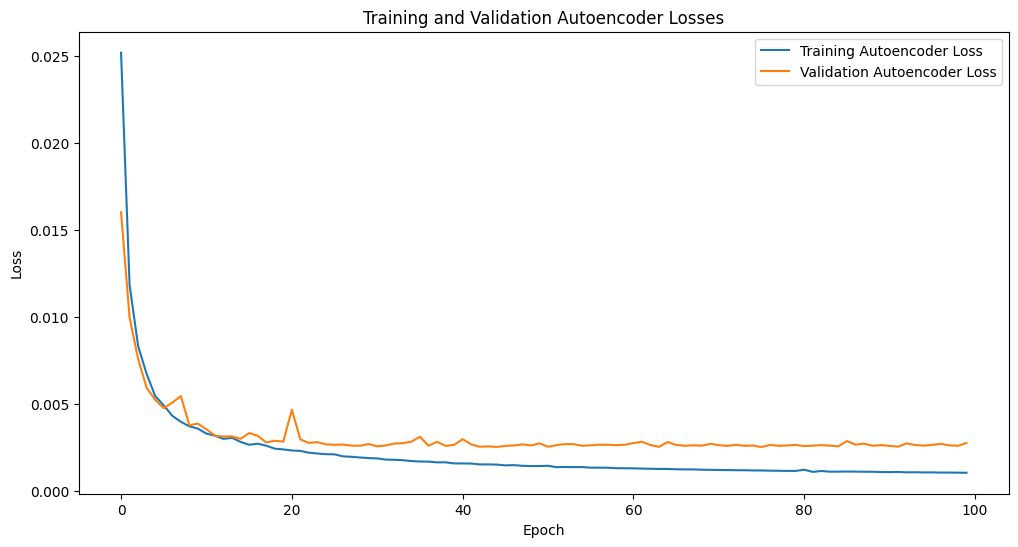

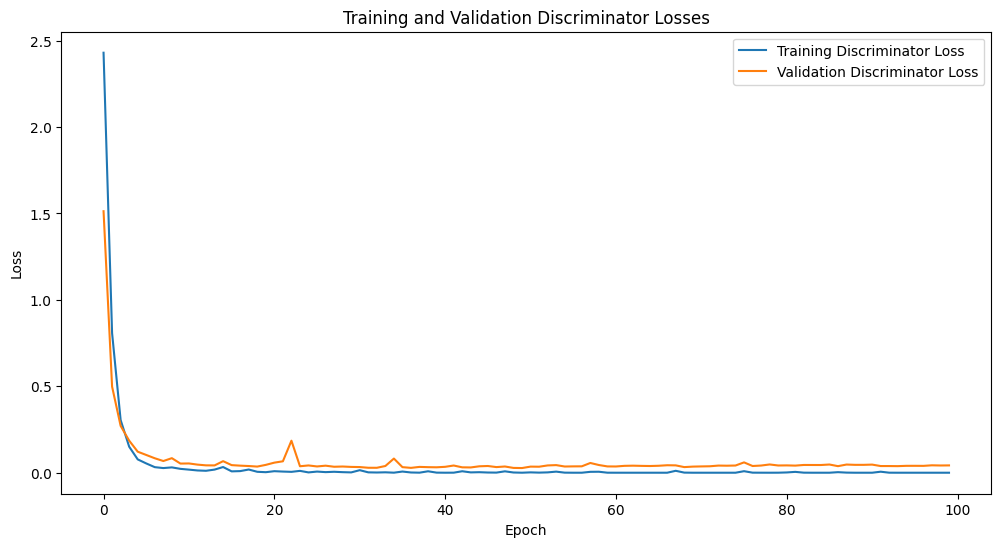

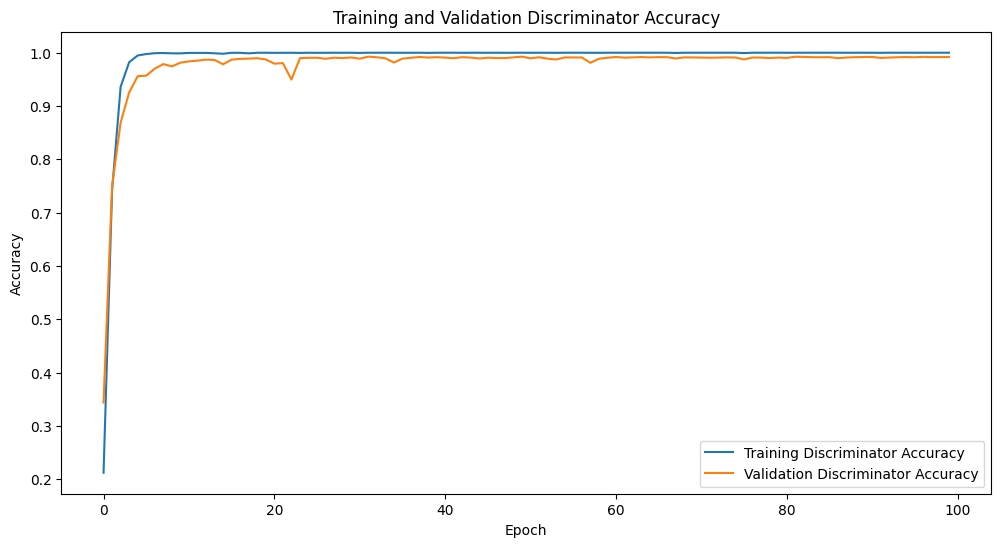

In [10]:
import matplotlib.pyplot as plt

# Plot autoencoder losses
plt.figure(figsize=(12, 6))
plt.plot(autoencoder_losses_epoch, label='Training Autoencoder Loss')
plt.plot(val_autoencoder_losses_epoch, label='Validation Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Autoencoder Losses')
plt.legend()
plt.savefig('autoencoder_losses.png')  # Save the plot as an image
plt.show()

# Plot discriminator losses
plt.figure(figsize=(12, 6))
plt.plot(discriminator_losses_epoch, label='Training Discriminator Loss')
plt.plot(val_discriminator_losses_epoch, label='Validation Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Discriminator Losses')
plt.legend()
plt.savefig('discriminator_losses.png')  # Save the plot as an image
plt.show()

# Plot discriminator accuracy
plt.figure(figsize=(12, 6))
plt.plot(discriminator_acc_epoch, label='Training Discriminator Accuracy')
plt.plot(val_discriminator_acc_epoch, label='Validation Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Discriminator Accuracy')
plt.legend()
plt.savefig('discriminator_accuracy.png')  # Save the plot as an image
plt.show()


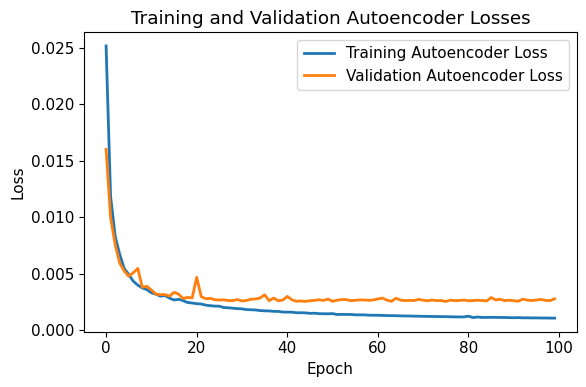

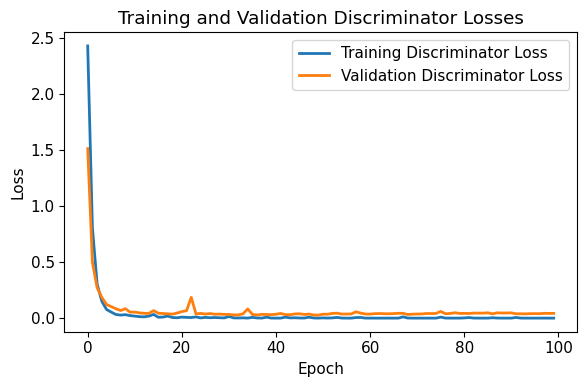

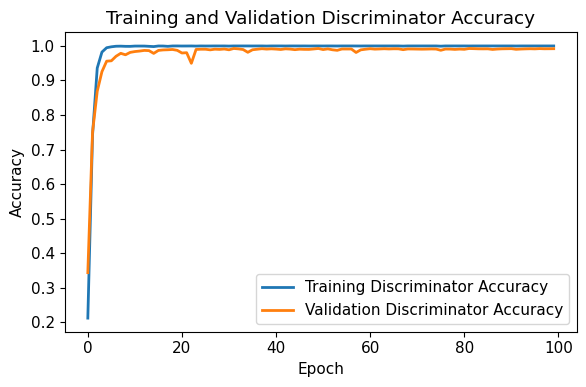

In [11]:
import matplotlib.pyplot as plt

# Set the font properties
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.size'] = 11  # Set font size to 11

# Plot autoencoder losses
plt.figure(figsize=(6, 4))  # Adjust figure size as needed
plt.plot(autoencoder_losses_epoch, label='Training Autoencoder Loss', linewidth=2)
plt.plot(val_autoencoder_losses_epoch, label='Validation Autoencoder Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Autoencoder Losses')
plt.legend()
plt.tight_layout()  # Adjust layout for better fit
plt.savefig('autoencoder_losses11.png', dpi=300)  # Save the plot as a high-resolution PNG
plt.show()
# Plot discriminator losses
plt.figure(figsize=(6, 4))  # Adjust figure size as needed
plt.plot(discriminator_losses_epoch, label='Training Discriminator Loss', linewidth=2)
plt.plot(val_discriminator_losses_epoch, label='Validation Discriminator Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Discriminator Losses')
plt.legend()
plt.tight_layout()  # Adjust layout for better fit
plt.savefig('discriminator_losses11.png', dpi=300)  # Save the plot as a high-resolution PNG
plt.show()
# Plot discriminator accuracy
plt.figure(figsize=(6, 4))  # Adjust figure size as needed
plt.plot(discriminator_acc_epoch, label='Training Discriminator Accuracy', linewidth=2)
plt.plot(val_discriminator_acc_epoch, label='Validation Discriminator Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Discriminator Accuracy')
plt.legend()
plt.tight_layout()  # Adjust layout for better fit
plt.savefig('discriminator_accuracy11.png', dpi=300)  # Save the plot as a high-resolution PNG
plt.show()

In [12]:
# Evaluate the discriminator on the train data
result = discriminator.evaluate(train_dataset)

# Print the result
print(f'Train Result: {result}')


 11/491 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 1.0000 - loss: 2.6335e-07

I0000 00:00:1716337073.112514      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


491/491 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 1.0000 - loss: 4.7331e-05
Train Result: [0.01158718578517437, 0.9999043345451355]


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Convert numerical class labels to strings
# Define the path to the test images
import pandas as pd
df = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')
test_dir = '/kaggle/input/gtsrb-german-traffic-sign/'

df['ClassId'] = df['ClassId'].astype(str)

# Define image data generator with preprocessing steps for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from dataframe to preprocess test images
test_generator = test_datagen.flow_from_dataframe(
    df,
    directory=test_dir,
    x_col='Path',
    y_col='ClassId',
    target_size=(64,64),
    batch_size=len(df),
    class_mode='categorical',  # 'categorical' returns one-hot encoded labels
    shuffle=False  # Do not shuffle for evaluation
)

# Get preprocessed test images and labels
X_test, y_test = next(test_generator)


Found 12630 validated image filenames belonging to 43 classes.


In [14]:
#130 epoch 93 percent

In [15]:
# Evaluate the discriminator on the test data   ##100 epoch
result = discriminator.evaluate(X_test, y_test)

# Print the result
print(f'Test Result: {result}')


395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9600 - loss: 0.2568
Test Result: [0.2860454320907593, 0.9621536135673523]


In [16]:
# Evaluate the discriminator on the test data   #125 epoch
result = discriminator.evaluate(X_test, y_test)

# Print the result
print(f'Test Result: {result}')


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9600 - loss: 0.2568
Test Result: [0.2860454320907593, 0.9621536135673523]


In [17]:
# Evaluate the discriminator on the test data  ##145 epoch
result = discriminator.evaluate(X_test, y_test)

# Print the result
print(f'Test Result: {result}')


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9600 - loss: 0.2568
Test Result: [0.2860454320907593, 0.9621536135673523]


In [18]:
import shutil
import os

# Specify the folder path
folder_path = '/kaggle/working/empty_folderf3'

# Create a zip file
shutil.make_archive(folder_path, 'zip', folder_path)

# Move the zip file to the output directory
output_path = '/kaggle/working/without_aug2.zip'
shutil.move(folder_path + '.zip', output_path)

# Display the download link
output_path
   

'/kaggle/working/without_aug2.zip'

In [19]:
discriminator.save('d_aug_valf.h5')

In [20]:
from sklearn.metrics import precision_recall_fscore_support

# Assuming you have test data predictions stored in y_pred and true labels in y_true
y_pred = discriminator.predict(X_test)
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, f1-score, and support for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred_labels)

# Average precision, recall, f1-score across all classes
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

# Print results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Support:", support)
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1_score)


395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Precision: [0.96610169 0.93774834 0.98340875 0.91208791 0.9942029  0.98353909
 1.         0.95454545 1.         1.         0.94444444 0.93650794
 0.97606383 0.81818182 0.98076923 0.96694215 0.86060606 0.96629213
 0.9625     0.91803279 0.75       0.99275362 0.88659794 0.92781316
 0.88617886 0.89966555 0.96774194 0.9952381  0.99166667 0.99481865
 0.97540984 0.96774194 0.98556999 0.97701149 0.98283931 0.9673913
 0.98214286 0.89108911 0.97034596 1.         0.95890411 0.92656587
 0.98532495]
Recall: [0.95       0.98333333 0.98787879 0.98809524 0.9942029  0.99583333
 1.         1.         0.99333333 0.98888889 0.87179487 0.98333333
 0.97866667 1.         0.56666667 0.975      0.94666667 0.95555556
 0.9625     0.93333333 0.5        0.91333333 0.95555556 0.97111111
 0.72666667 0.9962963  1.         0.9952381  0.99166667 0.98461538
 0.99166667 1.         0.98985507 0.94444444 0.95454545 0.98888889
 0.91666667 1.         0.93492063 0.82666667 0.93333333 0